In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [2]:
import datetime
import pyaurorax

aurorax = pyaurorax.PyAuroraX()

In [3]:
# download an hour of Gillam REGO data
dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2021, 11, 4, 3, 0)
end_dt = datetime.datetime(2021, 11, 4, 3, 59)
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid="gill")

In [4]:
# read in the hour of data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)

In [5]:
# set up working with the tools by just making a shorter name for our future calls
at = aurorax.tools

In [6]:
# determine the device UID for this camera
data.metadata[0]["Imager unique ID"]

'rego-652'

In [7]:
# download rayleighs calibration
dataset_name = "REGO_CALIBRATION_RAYLEIGHS_IDLSAV"
device_uid = "652"
r = aurorax.data.ucalgary.download_best_rayleighs_calibration(dataset_name, device_uid, start_dt)
r.filenames

[PosixPath('/home/josh/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15652_20141102-+_v01.sav')]

In [8]:
# in this case, there is only one calibration file available (sometimes there are more at later dates).
#
# read in the rayleighs calibration file
data_cal_rayleighs = aurorax.data.ucalgary.read(r.dataset, r.filenames[0])
data_cal_rayleighs.data[0].pretty_print()

Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15652
  filename                      : /home/josh/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15652_20141102-+_v01.sav
  flat_field_multiplier         : None
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     : 10.600000381469727
  version                       : v01


In [9]:
# download flatfield calibration
dataset_name = "REGO_CALIBRATION_FLATFIELD_IDLSAV"
device_uid = "652"
r = aurorax.data.ucalgary.download_best_rayleighs_calibration(dataset_name, device_uid, start_dt)
r.filenames

[PosixPath('/home/josh/pyaurorax_data/REGO_CALIBRATION_FLATFIELD_IDLSAV/REGO_flatfield_15652_20141102-+_v01.sav')]

In [10]:
# in this case, there is only one calibration file available (sometimes there are more at later dates).
#
# read in the rayleighs calibration file
data_cal_flatfield = aurorax.data.ucalgary.read(r.dataset, r.filenames[0])
data_cal_flatfield.data[0].pretty_print()

Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15652
  filename                      : /home/josh/pyaurorax_data/REGO_CALIBRATION_FLATFIELD_IDLSAV/REGO_flatfield_15652_20141102-+_v01.sav
  flat_field_multiplier         : array(dims=(512, 512), dtype=>f8)
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     : None
  version                       : v01


# Apply dark frame correction

In [11]:
calibrated_data = at.calibration.rego(data.data[:, :, 0:5], step_flatfield_calibration=False, step_rayleighs_calibration=False)

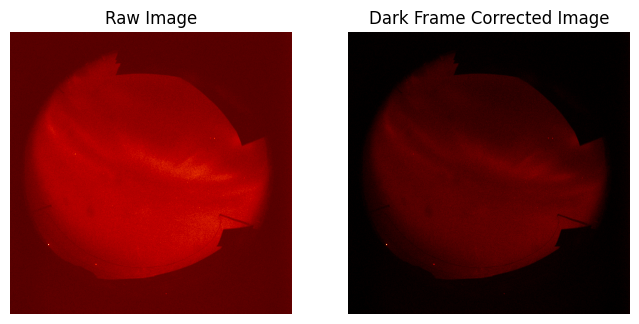

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title("Raw Image")
ax1.imshow(at.scale_intensity(data.data[:, :, 0], min=0, max=1000), cmap='gist_heat', origin="lower")
ax1.axis('off')
ax2.set_title("Dark Frame Corrected Image")
ax2.imshow(at.scale_intensity(calibrated_data[:, :, 0], min=0, max=1000), cmap='gist_heat', origin="lower")
ax2.axis('off')
plt.show()

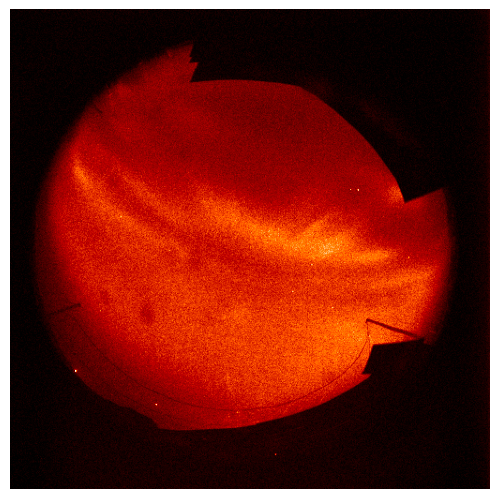

In [13]:
at.display(at.scale_intensity(calibrated_data[:, :, 0], min=0, max=400), cmap="gist_heat")

# Apply flatfield correction too

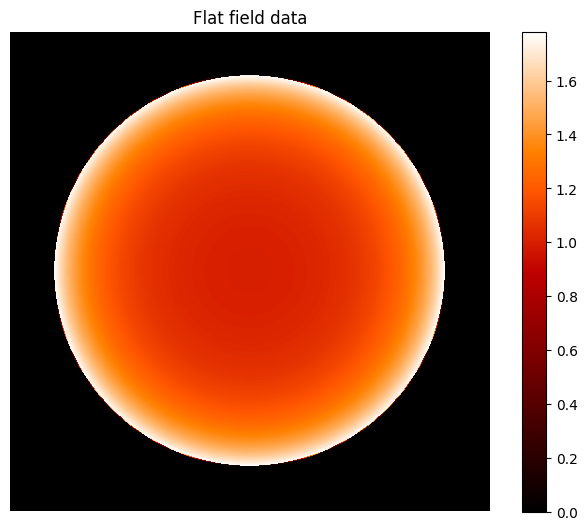

In [14]:
at.display(data_cal_flatfield.data[0].flat_field_multiplier, cmap="gist_heat", title="Flat field data", colorbar=True)

In [15]:
calibrated_data = at.calibration.rego(data.data[:, :, 0:5], cal_flatfield=data_cal_flatfield.data[0], step_rayleighs_calibration=False)

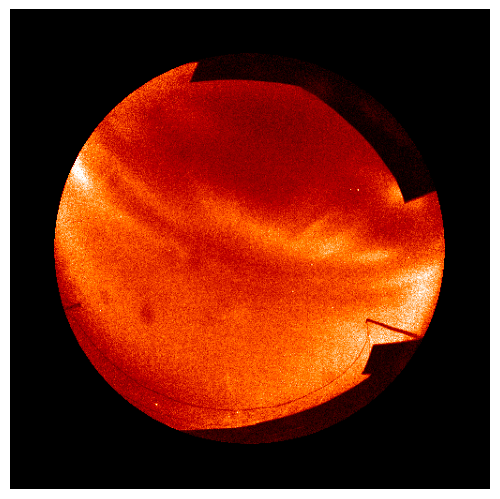

In [16]:
at.display(at.scale_intensity(calibrated_data[:, :, 0], min=0, max=400), cmap="gist_heat")

# Apply Rayleighs conversion too

In [17]:
calibrated_data = at.calibration.rego(
    data.data[:, :, 600],
    cal_flatfield=data_cal_flatfield.data[0],
    cal_rayleighs=data_cal_rayleighs.data[0],
)

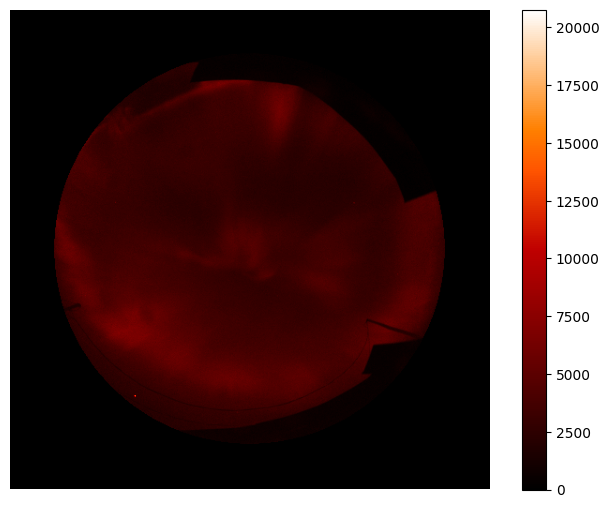

In [18]:
at.display(calibrated_data, cmap="gist_heat", colorbar=True)

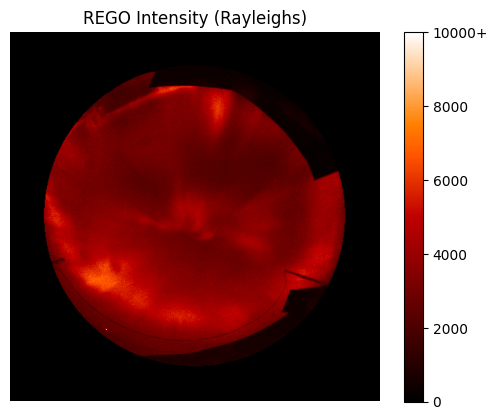

In [19]:
# cap the scale at a certain Rayleighs
import numpy as np

max_cutoff = 10000
calibrated_data = at.calibration.rego(
    data.data[:, :, 600],
    cal_flatfield=data_cal_flatfield.data[0],
    cal_rayleighs=data_cal_rayleighs.data[0],
)
calibrated_data[np.where(calibrated_data > max_cutoff)] = max_cutoff

plt.imshow(calibrated_data, cmap="gist_heat", vmin=0, vmax=max_cutoff, origin="lower")
plt.axis("off")
plt.title("REGO Intensity (Rayleighs)")

# Create a colorbar, in Rayleighs, that accounts for the scaling limit we applied
cbar_ticks = [float(max_cutoff) / 5. * j for j in range(0, 6)]
cbar_ticknames = [str(int(max_cutoff / 5) * j) for j in range(0, 6)]

# Any pixels with the max Rayleigh value could be greater than it, so we include the plus sign
cbar_ticknames[-1] += '+'
cbar = plt.colorbar(ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticknames)
plt.show()